<table width="100%" border="3">
  <tbody>
    <tr>
      <td ><img src="https://aidea-web.tw/images/web/logo_white.png" alt="Aidea" width="400"/></td>
      <td align='left'><h1>Exercise 1: AOI full pipeline </h1></td>
    </tr>
  </tbody>
</table>

# (2): AOI full pipeline
* single CNN model
* ImageDataGenerator
* ModelCheckpoint
* EarlyStopping
* Submit results

## Step 1: Load the dataset from google drive
https://drive.google.com/file/d/1QXygjos-6UZKrHNsR0as5jhlQU4JK4R9/view?usp=sharing

In [ ]:
from google_drive_downloader import GoogleDriveDownloader
GoogleDriveDownloader.download_file_from_google_drive(file_id='1QXygjos-6UZKrHNsR0as5jhlQU4JK4R9',dest_path='./content', unzip=True)

Unzipping...Done.


## Step 2: Import python libraries

In [ ]:
import tensorflow as tf
#tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.4.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

## Step 3: read the training set

In [ ]:
import pandas as pd
df_train = pd.read_csv("train.csv",dtype=str )
print(df_train.shape)

(5056, 2)


In [ ]:
df_train.head()

,ID,Label
0,train_00000.jpg,0
1,train_00001.jpg,1
2,train_00002.jpg,1
3,train_00003.jpg,5
4,train_00004.jpg,5


In [ ]:
train_files = df_train.iloc[:,0].values
train_labels = df_train.iloc[:,1].values
print(train_labels[:10])

['0' '1' '1' '5' '5' '5' '3' '0' '3' '5']


## Step 4: Show statistics of training images 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


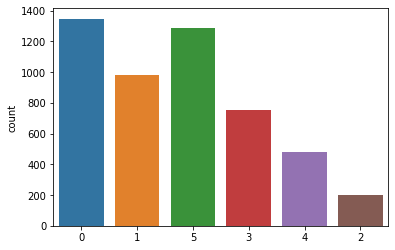

In [ ]:
import seaborn as sns
g = sns.countplot(train_labels)

In [ ]:
num_classes=6

## Step 5: Choose one of CNN models 
* DenseNet121(...): Instantiates the Densenet121 architecture.
* DenseNet169(...): Instantiates the Densenet169 architecture.
* DenseNet201(...): Instantiates the Densenet201 architecture.
* InceptionResNetV2(...): Instantiates the Inception-ResNet v2 architecture.
* InceptionV3(...): Instantiates the Inception v3 architecture.
* MobileNet(...): Instantiates the MobileNet architecture.
* MobileNetV2(...): Instantiates the MobileNetV2 architecture.
* NASNetLarge(...): Instantiates a NASNet model in ImageNet mode.
* NASNetMobile(...): Instantiates a Mobile NASNet model in ImageNet mode.
* ResNet101(...): Instantiates the ResNet101 architecture.
* ResNet101V2(...): Instantiates the ResNet101V2 architecture.
* ResNet152(...): Instantiates the ResNet152 architecture.
* ResNet152V2(...): Instantiates the ResNet152V2 architecture.
* ResNet50(...): Instantiates the ResNet50 architecture.
* ResNet50V2(...): Instantiates the ResNet50V2 architecture.
* VGG16(...): Instantiates the VGG16 model.
* VGG19(...): Instantiates the VGG19 architecture.
* Xception(...): Instantiates the Xception architecture.


In [ ]:
from tensorflow.keras.applications import InceptionV3
model = InceptionV3(include_top = True, input_shape=(299,299,3), weights=None, classes=num_classes)

In [ ]:
from tensorflow.keras.applications import EfficientNetB1
base_model = EfficientNetB1(include_top = False, input_shape=(299,299,3), weights="imagenet")

27025408/27018416 [==============================] - 0s 0us/step


In [ ]:
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalMaxPooling2D(name="gap"))
#avoid overfitting
model.add(layers.Dropout(rate=0.2, name="dropout_out"))
# Set NUMBER_OF_CLASSES to the number of your final predictions.
model.add(layers.Dense(num_classes, activation="softmax", name="fc_out"))

In [ ]:
model.summary()

## Step 6: Instancing an ImageDataGenerator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input
img_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

## Step 7: Set up a train_generator with flow_from_dataframe

In [ ]:
train_generator = img_gen.flow_from_dataframe(dataframe=df_train,
            directory="train_images",
            x_col="ID",
            y_col="Label",
            subset=None,
            batch_size=8,
            shuffle=False,
            class_mode="categorical",
            color_mode="rgb",
            target_size=(299,299))

Found 5056 validated image filenames belonging to 6 classes.


In [ ]:
train_generator.class_indices

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}

## Step 8: step_size_train

In [ ]:
if train_generator.n % train_generator.batch_size ==0:
  step_size_train=train_generator.n//train_generator.batch_size
else:
  step_size_train=train_generator.n//train_generator.batch_size + 1
print(step_size_train)

632


## Step 9: ModelCheckpoint

In [ ]:
# Include the epoch in the file name (uses `str.format`)
import os
checkpoint_path = "training_cp/cp-{epoch:03d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights 
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path , save_weights_only=True)

## Step 10: EarlyStopping

In [ ]:
# Create a callback that stop the model 
es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

## Step 11: Compile model

In [ ]:
#compile model using accuracy to measure model performance
from tensorflow.keras import optimizers
model.compile(loss='categorical_crossentropy',
            optimizer=optimizers.Adam(lr=3e-3),
            metrics=['accuracy'])

## Step 12: Train model

In [ ]:
hist = model.fit(train_generator, steps_per_epoch=step_size_train, callbacks=[cp_callback, es_callback], epochs=100)

Epoch 1/100
607/632 [===========================>..] - ETA: 5s - loss: 2.2839 - accuracy: 0.6532

## Step 13: Evaluate saved checkpoints

In [ ]:
##checkpoint 1
model.load_weights("training_cp/cp-020.ckpt")
train_generator.reset()
model.evaluate_generator(generator=train_generator, steps=step_size_train, verbose=1)

In [ ]:
##checkpoint 2
model.load_weights("training_cp/cp-019.ckpt")
train_generator.reset()
model.evaluate_generator(generator=train_generator, steps=step_size_train, verbose=1)

In [ ]:
##checkpoint 3
model.load_weights("training_cp/cp-018.ckpt")
train_generator.reset()
model.evaluate_generator(generator=train_generator, steps=step_size_train, verbose=1)

## Step 14: Save the trained model

In [ ]:
model.load_weights("training_cp/cp-020.ckpt")
model.save("AOI-InceptionV3-0128.h5")

## Step 15: Check training results

In [ ]:
#y_predictions = model.predict(X_train, batch_size=20)
train_generator.reset()
y_predictions = model.predict_generator(generator=train_generator, steps=step_size_train, verbose=1)

In [ ]:
print(y_predictions[:2])
type(y_predictions)

In [ ]:
predicts = np.argmax(y_predictions,axis=1)
print(predicts[0:10])

In [ ]:
labels = train_labels.astype(int)
print(labels[:10])

## Step 16: Analyze training results


In [ ]:
from sklearn.metrics import confusion_matrix
confusion=confusion_matrix(labels, predicts)
print(confusion)

In [ ]:
train_num= 2528
overkill= []
underkill = []
for i in range(train_num):
  if labels[i] == 0 and predicts[i] !=0:
    overkill.append(i)
  if labels[i] != 0 and predicts[i] ==0:
    underkill.append(i)
print('# of overkill= {}; # of underkill= {} '.format(len(overkill), len(underkill)))

## Step 17: Load the test set 

In [ ]:
df_test = pd.read_csv("test.csv",dtype=str)
print(df_test.shape)

In [ ]:
df_test.head()

In [ ]:
test_files  = df_test.iloc[:,0].values
test_labels = df_test.iloc[:,1].values
print(test_labels[:10])

## Step 18: Set up a test_generator with flow_from_dataframe

In [ ]:
test_generator = img_gen.flow_from_dataframe(dataframe=df_test,
            directory="test_images",
            x_col="ID",
            y_col="Label",
            batch_size=32,
            shuffle=False,
            class_mode=None,
            target_size=(299,299))

## Step 19: step_size_test

In [ ]:
if test_generator.n % test_generator.batch_size ==0:
  step_size_test=test_generator.n//test_generator.batch_size
else:
  step_size_test=test_generator.n//test_generator.batch_size + 1
print(step_size_test)

## Step 20: Check test results

In [ ]:
#y_predictions = model.predict(X_train, batch_size=20)
test_generator.reset()
y_predictions = model.predict_generator(generator=test_generator, steps=step_size_test,verbose=1)

In [ ]:
import numpy as np
predicts=np.argmax(y_predictions,axis=1)
predicts[:10]

In [ ]:
len(predicts)

## Step 21: Output test results

In [ ]:
df_out = pd.DataFrame(df_test)
df_out.shape

In [ ]:
df_out['Label'] = predicts
df_out.to_csv("0128-aoi.csv", index=False)